In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mshr
import numpy as np
import scipy.integrate as integrate
from fenics import *

# DIMENSIONS

In [2]:
L_mot = .1
l_mot = .001
n_trou = 1
L_1 = .003
l_1 = .005
L_2 = .005
l_2 = .015
L_3 = .003
l_3 = .005
Delta_vert_12 = .005
Delta_vert_23 = .005
L_vide = .3
l_vide = .05

In [3]:
Delta_horiz_1 = L_mot/n_trou - L_1
Delta_horiz_2 = L_mot/n_trou - L_2
Delta_horiz_3 = L_mot/n_trou - L_3
h_grille = l_1 + l_2 + l_3 + Delta_vert_12 + Delta_vert_23

# MAILLAGE

In [4]:
def segment(Point1,Point2):
    """
    Renvoie une liste des 4 coordonnées des extrémités à partir des deux points donnés
    [x1,y1,x2,y2]
    """
    return [Point1[0],Point1[1],Point2[0],Point2[1]]

def rect(Point1,Point2):
    """
    Renvoie les 4 listes des coordonnées des segments construisant le rectangle issu des 2 points d'entrée
    ([x1,y1,x2,y2], [x1,y1,x2,y2], [x1,y1,x2,y2], [x1,y1,x2,y2])
    """
    s1=segment(Point1, Point(Point1[0],Point2[1]))
    s2=segment(Point(Point1[0],Point2[1]), Point2)
    s3=segment(Point2, Point(Point2[0],Point1[1]))
    s4=segment(Point(Point2[0],Point1[1]), Point1)
    return (s1,s2,s3,s4)

In [5]:
P1 = Point(-L_mot/2, -l_mot/2)
P2 = Point(L_mot/2, l_mot/2)
P3 = P1 + Point(L_mot, -h_grille)
P4 = P1 + Point(-(L_vide-L_mot)/2, -(h_grille+l_vide))
P5 = P3 + Point((L_vide-L_mot)/2, 0)

moteur = mshr.Rectangle(P1, P2)
grille = mshr.Rectangle(P1, P3)
vide = mshr.Rectangle(P4, P5)

zone = moteur + grille + vide

P6 = P1 + Point(L_1/2, -l_1)
P7 = P6 + Point(-L_1/2 , -Delta_vert_12)
P8 = P7 + Point(L_2/2, -l_2)
P9 = P8 + Point(-L_2/2, -Delta_vert_23)
P10 = P9 + Point(L_3/2, -l_3)
P11 = P3 + Point(-L_3/2, l_3)
P12 = P11 + Point(L_3/2, Delta_vert_23)
P13 = P12 + Point(-L_2/2, l_2)
P14 = P13 + Point(L_2/2, Delta_vert_12)
P15 = P14 + Point(-L_1/2, l_1)

rect_1 = mshr.Rectangle(P1, P6)
rect_2 = mshr.Rectangle(P7, P8)
rect_3 = mshr.Rectangle(P9, P10)
rect_4 = mshr.Rectangle(P3, P11)
rect_5 = mshr.Rectangle(P12, P13)
rect_6 = mshr.Rectangle(P14, P15)

zone -= (rect_1 + rect_2 + rect_3 + rect_4 + rect_5 + rect_6)

liste_segment=[
    segment(P1,P2+Point(-L_mot,l_mot)),
    segment(P2+Point(-L_mot,l_mot),P2), 
    segment(P2, P15+Point(L_1/2,0)),
    segment(P15+Point(L_1/2,0), P15),
    segment(P15, P15+Point(0,-l_1)),
    segment(P15+Point(0,-l_1), P14),
    segment(P14, P14+Point(0,-Delta_vert_12)),
    segment(P14+Point(0,-Delta_vert_12), P13),
    segment(P13, P13+Point(0, -l_2)),
    segment(P13+Point(0, -l_2), P12),
    segment(P12, P12+Point(0,-Delta_vert_23)),
    segment(P12+Point(0,-Delta_vert_23), P11),
    segment(P11, P11+Point(0, -l_3)),
    segment(P11+Point(0, -l_3), P5),
    segment(P5, P5+Point(0,-l_vide)),
    segment(P5+Point(0,-l_vide), P4),
    segment(P4, P4+Point(0,l_vide)),
    segment(P4+Point(0,l_vide), P10),
    segment(P10, P10+Point(0,l_3)),
    segment(P10+Point(0,l_3),P9),
    segment(P9,P9+Point(0,Delta_vert_23)),
    segment(P9+Point(0,Delta_vert_23),P8),
    segment(P8, P8+Point(0, l_2)),
    segment(P8+Point(0, l_2), P7),
    segment(P7, P7+Point(0,Delta_vert_12)),
    segment(P7+Point(0,Delta_vert_12), P6),
    segment(P6, P6+Point(0,l_1)),
    segment(P6+Point(0,l_1),P1)
    ]

In [6]:
for i in range (n_trou-1):
    PN1 = P6 + Point((i+1)*Delta_horiz_1 + i*L_1, 0)
    PN2 = PN1 + Point(L_1, l_1)
    PN3 = P8 + Point((i+1)*Delta_horiz_2 + i*L_2, 0)
    PN4 = PN3 + Point(L_2, l_2)
    PN5 = P10 + Point((i+1)*Delta_horiz_3 + i*L_3, 0)
    PN6 = PN5 + Point(L_3, l_3)
    
    rectN_1 = mshr.Rectangle(PN1, PN2)
    rectN_2 = mshr.Rectangle(PN3, PN4)
    rectN_3 = mshr.Rectangle(PN5, PN6)
    
    zone -= (rectN_1 + rectN_2 + rectN_3)
    
    s1,s2,s3,s4=rect(PN1,PN2)
    liste_segment.append(s1)
    liste_segment.append(s2)
    liste_segment.append(s3)
    liste_segment.append(s4)
    
    s1,s2,s3,s4=rect(PN3,PN4)
    liste_segment.append(s1)
    liste_segment.append(s2)
    liste_segment.append(s3)
    liste_segment.append(s4)
    
    s1,s2,s3,s4=rect(PN5,PN6)
    liste_segment.append(s1)
    liste_segment.append(s2)
    liste_segment.append(s3)
    liste_segment.append(s4)

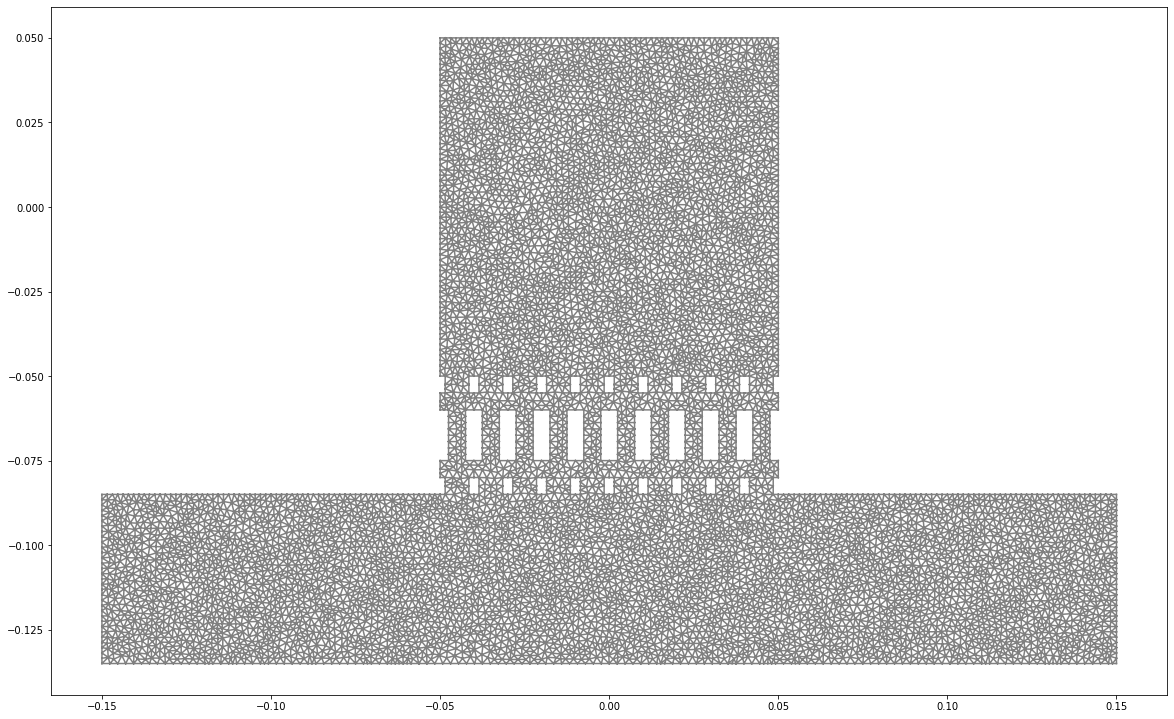

In [7]:
mesh=mshr.generate_mesh(zone, 100)

plt.figure(figsize=(20,20))
plot(mesh)
plt.show()

# CALCUL DE E

In [8]:
Phi_mot=0
#Phi_vide=Phi_mot #Neumann pr le moment
Phi_electrode2=100
Phi_electrode3=200
rhoelec=0
permittivité=1

In [9]:
V = FunctionSpace(mesh, 'P', 1)
W = VectorFunctionSpace(mesh, 'P', 1)

class Boundary_mot(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and x[1] >= - l_mot/2 - l_1
    
class Boundary_vide(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and ( x[1] < - l_mot/2 - h_grille or (x[1] == - l_mot/2 - h_grille and abs(x[0]) > L_mot/2) )
    
class Boundary_electrode2(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and x[1] <= - l_mot/2 - l_1 - Delta_vert_12 and x[1] >= - l_mot/2 - l_1 - Delta_vert_12 - l_2
    
class Boundary_electrode3(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and x[1] <= - l_mot/2 - l_1 - Delta_vert_12 - l_2 - Delta_vert_23 and x[1] >= - l_mot/2 - l_1 - Delta_vert_12 - l_2 - Delta_vert_23 - l_3 and abs(x[0]) <= L_mot/2
    
boundary_mot = Boundary_mot()
#boundary_vide = Boundary_vide() #Neumann pr le moment
boundary_electrode2 = Boundary_electrode2()
boundary_electrode3 = Boundary_electrode3()

bc_mot = DirichletBC(V, Constant(Phi_mot), boundary_mot)
#bc_vide = DirichletBC(V, Constant(Phi_vide), boundary_vide) #Neumann pr le moment
bc_electrode2 = DirichletBC(V, Constant(Phi_electrode2), boundary_electrode2)
bc_electrode3 = DirichletBC(V, Constant(Phi_electrode3), boundary_electrode3)

bc = [bc_mot, bc_electrode2, bc_electrode3]

In [10]:
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(rhoelec/permittivité) 
a = dot(grad(u), grad(v))*dx
L = f*v*dx
Phi = Function(V)

solve(a == L, Phi, bc)

E = project(-grad(Phi), W)
Ex, Ey = E.split(deepcopy=True)
NE=sqrt(dot(E,E))

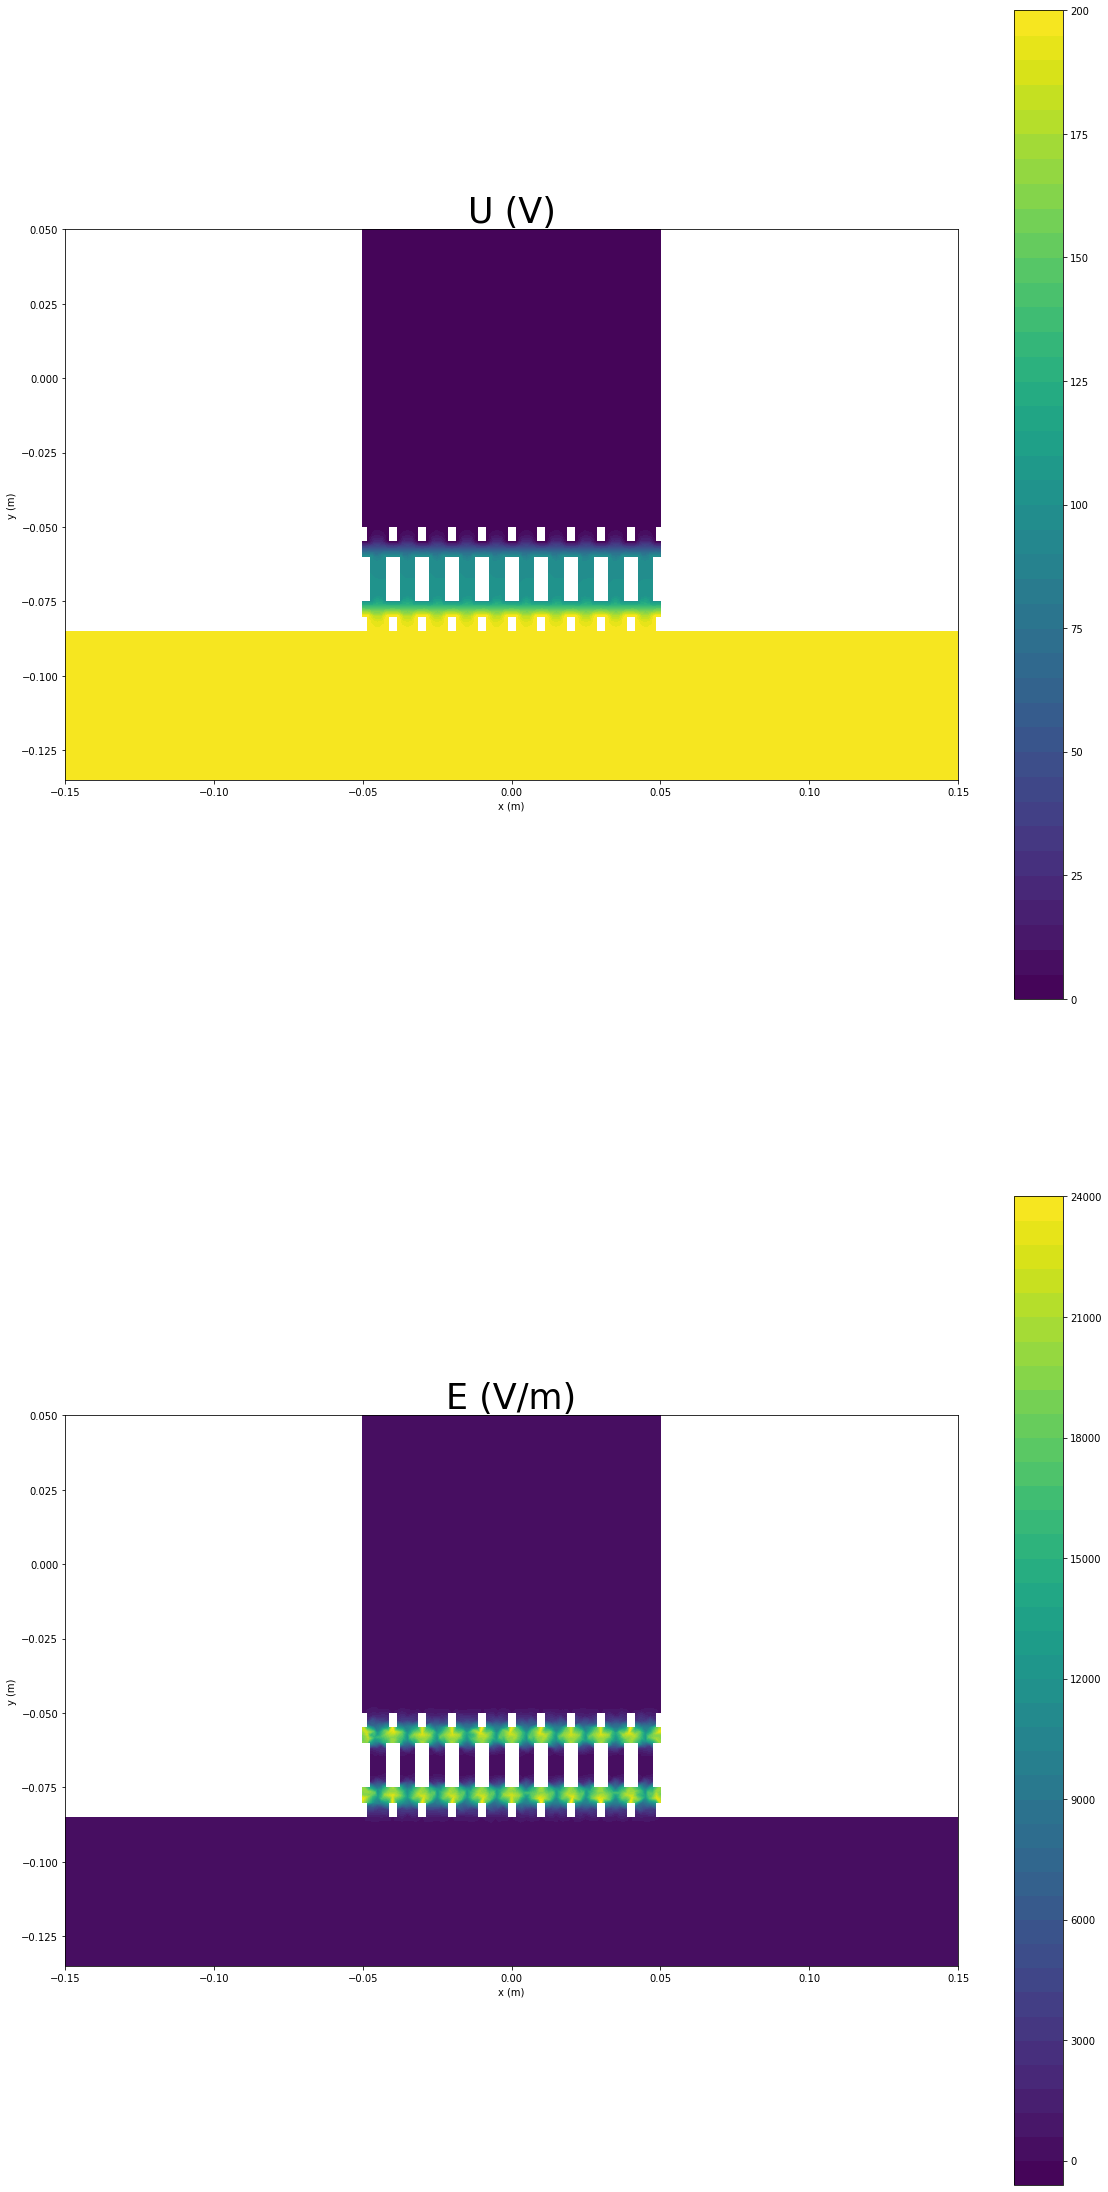

In [11]:
plt.figure(figsize=(20,40))

plt.subplot(2,1,1)
fig=plot(Phi)
plt.title('U (V)', size=35)
plt.xlabel('x (m)',size=10)
plt.ylabel('y (m)',size=10)
fig.set_cmap("viridis") 
plt.colorbar(fig)

plt.subplot(2,1,2)
fig=plot(NE)
plt.title('E (V/m)', size=35)
plt.xlabel('x (m)',size=10)
plt.ylabel('y (m)',size=10)
fig.set_cmap("viridis") 
plt.colorbar(fig)

plt.show()

# CALCUL DE TRAJECTOIRE

In [17]:
tmax =10
dt = .00001
t = 0

m_part = 1
q_part = -1e-16
x0 = -.007
y0 = 0
vx0 = .1
vy0 = .01

Y=np.array([x0, y0, vx0, vy0])
liste_x=[x0]
liste_y=[y0]
liste_vx=[vx0]
liste_vy=[vy0]
listet=[0] #pas un linspace au cas où on arrête avant
N_impact=0

In [18]:
def intersection(x1,y1,x2,y2,x3,y3,x4,y4): #donne les coords d'inters des segments 1,2 et 3,4 #n='NO' si n'existe pas, 'x'ou'y' selon la normale #d'impact de  1,2 sur 3,4
    """
    Donne les coordonnées d'intersection des segments 1,2 et 3,4 en assumant que 3,4 est forcément vertical ou horizontal
    Renvoie aussi la normale au segment 3,4 (ici la normale au plan percuté)
    
    Si impact il y a eu, la sortie est de type (xi,yi,'x') ou (xi,yi,'y'). Sinon, renvoie (0,0,'NO')
    """
    if x3==x4: #segment vert
        if x2==x1: #parallelisme
            return (0,0,'NO')
        if (x1-x3)*(x2-x3)>0:  #du meme cote de ce segment
            return (0,0,'NO')
        pente_traj=(y2-y1)/(x2-x1)
        b_traj=y1-pente_traj*x1
        y_test=pente_traj*x3+b_traj
        if y_test<=max(y3,y4) and y_test>=min(y3,y4):
            return (x3,y_test,'x')
        return (0,0,'NO')
    else:    #segment horiz
        if y1==y2: #parallelisme
            return (0,0,'NO')
        if (y1-y3)*(y2-y3)>0:  #du meme cote de ce segment
            return (0,0,'NO')
        if x1==x2: #autre seg ss notion de pente
            if x1<=max(x3,x4) and x1>=min(x3,x4):
                return (x1,y3,'y')
            return (0,0,'NO')
        pente_traj=(y2-y1)/(x2-x1)
        b_traj=y1-pente_traj*x1
        x_test=(y3-b_traj)/pente_traj
        if x_test<=max(x3,x4) and x_test>=min(x3,x4):
            return (x_test,y3,'y')
        return (0,0,'NO')

def coord_impact(x1,y1,x2,y2): #cherche où et selon quelle n le segments 1,2 coupe un bord
    """
    On sait que ce segment coupe un bord, On cherche alors quel segment il coupe ainsi que les coordonnées d'intersection et la normale
    Renvoie (xi,yi,n) ou n='x'ou'y'
    Par défaut (normalement jamais), renvoie (0,0,'NO') s'il ne coupe rien
    """
    for segment in liste_segment:
        x3,y3,x4,y4=segment
        xi,yi,n=intersection(x1,y1,x2,y2,x3,y3,x4,y4)
        if n!='NO':
            return (xi,yi,n)
    return (0,0,'NO')

In [19]:
def f(Y,t): #Y=[x,y,vx,vy]
    """
    Renvoie la dérivée de Y en y (en faisant un bilan des forces notamment) pr être entré dans RK4
    """
    vx=Y[2]
    vy=Y[3]
    if zone.inside(Point(Y[0],Y[1])):
        ax = (1/m_part) * q_part * Ex(Y[0], Y[1])
        ay = (1/m_part) * q_part * Ey(Y[0], Y[1])
    else :
        ax = 0  #utile si les ki st hors du mesh
        ay = 0
    return [vx, vy, ax, ay]

In [20]:
"""
RK4 où Y est le vecteur au temps t de la boucle.
Les positions et vitesses et le temps correspondants sont en parallèles stockés dans les listes: liste_x, liste_vy ...
Notons une erreur notable, lors des calculs des Ki, on considère qu'il n'y a pas de rebonds possibles sur la trajectoire interpolée
d'où les cas de champ E nul dans f

Autre truc à étudier: si après le calcul du rebond, on retombe hors du mesh, potentiellement pas d'intersection à l'iteraion suivante
"""

while t<=tmax:
    k1=np.array(f(Y,t))
    k2=np.array(f(Y+.5*dt*k1, t+.5*dt))
    k3=np.array(f(Y+.5*dt*k2, t+.5*dt))
    k4=np.array(f(Y+dt*k3, t+dt))
    Y_pot=Y+dt*(1/6*k1+1/3*k2+1/3*k3+1/6*k4)
    if zone.inside(Point(Y_pot[0],Y_pot[1]))==True:
        Y=Y_pot
    else:
        xinter,yinter,n=coord_impact(Y[0],Y[1],Y_pot[0],Y_pot[1])
        N_impact+=1
        if n=='x': #normale selon x
            Y=np.array([xinter+(xinter-Y_pot[0]),Y_pot[1],-Y_pot[2],Y_pot[3]])
        else:
            Y=np.array([Y_pot[0],yinter+(yinter-Y_pot[1]),Y_pot[2],-Y_pot[3]])
    liste_x.append(Y[0])
    liste_y.append(Y[1])
    liste_vx.append(Y[2])
    liste_vy.append(Y[3])
    listet.append(t)
    t+=dt
    if Y[1]<-l_mot/2-h_grille:
        break

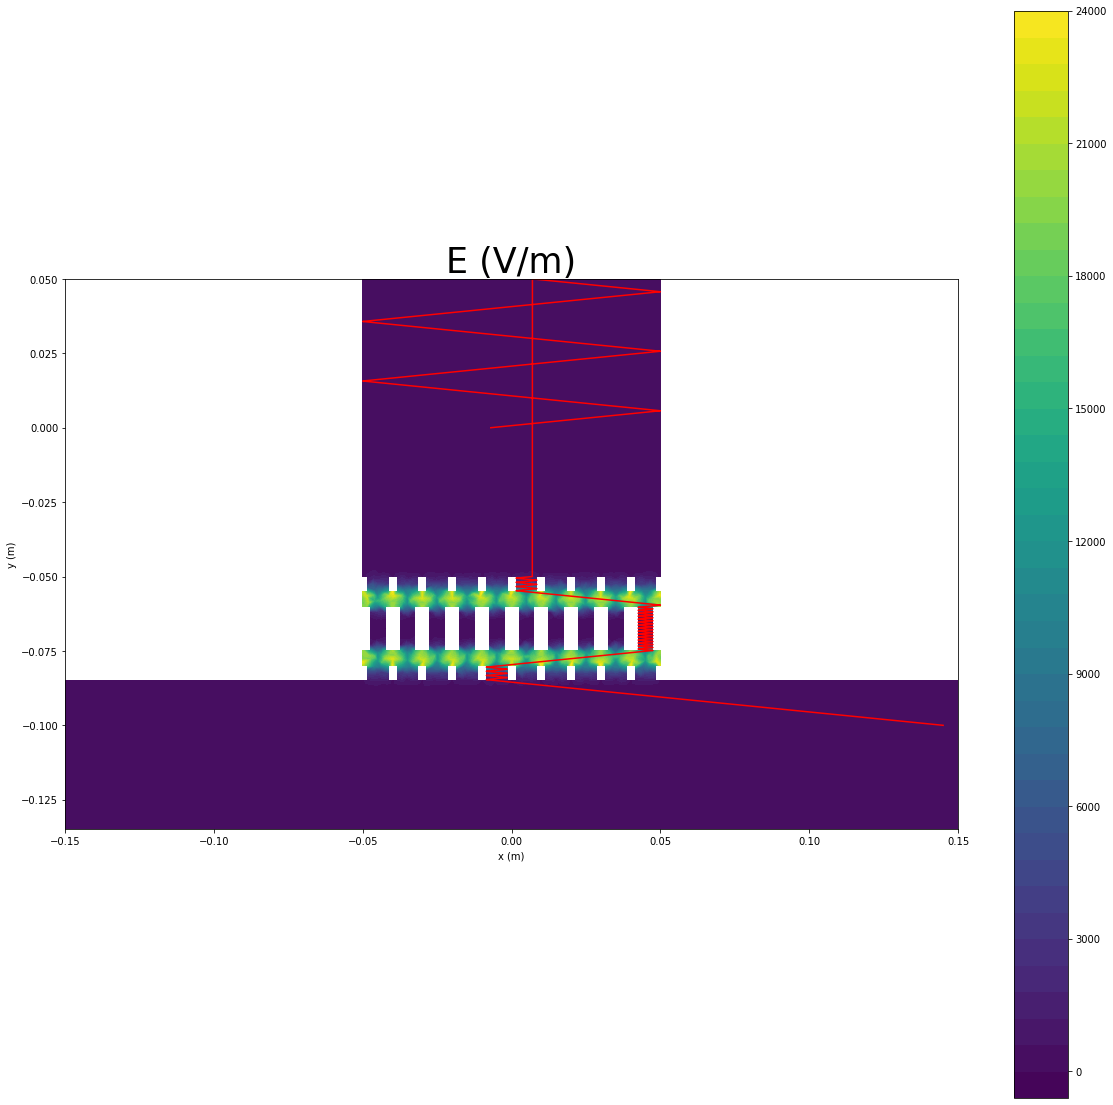

In [21]:
plt.figure(figsize=(20,20))
fig=plot(NE)
plt.plot(liste_x,liste_y,linestyle='-',color='r')
plt.scatter(liste_x[0],liste_y[0],color='r')
plt.scatter(liste_x[-1],liste_y[-1],color='r')
plt.title('E (V/m)', size=35)
plt.xlabel('x (m)',size=10)
plt.ylabel('y (m)',size=10)
fig.set_cmap("viridis") 
plt.colorbar(fig)

plt.show()

In [ ]:
print('N_impact=',N_impact)
print('alpha=',np.arctan(-liste_vx[-1]/liste_vy[-1]))